# 论文6: 指针网络
## Oriol Vinyals, Meire Fortunato, Navdeep Jaitly

### 实现：基于注意力的指向机制

指针网络使用注意力来指向输入元素，解决凸包和TSP等组合问题。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 用于指向的注意力机制

In [2]:
def softmax(x, axis=-1):
    """Stable softmax"""
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class PointerAttention:
    def __init__(self, hidden_size):
        self.hidden_size = hidden_size
        
        # Attention parameters
        self.W1 = np.random.randn(hidden_size, hidden_size) * 0.1
        self.W2 = np.random.randn(hidden_size, hidden_size) * 0.1
        self.v = np.random.randn(hidden_size, 1) * 0.1
    
    def forward(self, encoder_states, decoder_state):
        """
        Compute attention scores over input elements
        
        encoder_states: (seq_len, hidden_size) - encoded input
        decoder_state: (hidden_size, 1) - current decoder state
        
        Returns:
        probs: (seq_len, 1) - pointer distribution over inputs
        """
        seq_len = encoder_states.shape[0]
        
        # Compute attention scores
        scores = []
        for i in range(seq_len):
            # e_i = v^T * tanh(W1*encoder_state + W2*decoder_state)
            encoder_proj = np.dot(self.W1, encoder_states[i:i+1].T)
            decoder_proj = np.dot(self.W2, decoder_state)
            score = np.dot(self.v.T, np.tanh(encoder_proj + decoder_proj))
            scores.append(score[0, 0])
        
        scores = np.array(scores).reshape(-1, 1)
        
        # Softmax to get probabilities
        probs = softmax(scores, axis=0)
        
        return probs, scores

# Test attention
hidden_size = 32
attention = PointerAttention(hidden_size)

# Dummy encoder states and decoder state
seq_len = 5
encoder_states = np.random.randn(seq_len, hidden_size)
decoder_state = np.random.randn(hidden_size, 1)

probs, scores = attention.forward(encoder_states, decoder_state)
print(f"Pointer Network Attention initialized")
print(f"Attention probabilities sum: {probs.sum():.4f}")
print(f"Probabilities shape: {probs.shape}")

Pointer Network Attention initialized
Attention probabilities sum: 1.0000
Probabilities shape: (5, 1)


## 完整的指针网络架构

In [3]:
class PointerNetwork:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Encoder (simple RNN)
        self.encoder_Wx = np.random.randn(hidden_size, input_size) * 0.1
        self.encoder_Wh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.encoder_b = np.zeros((hidden_size, 1))
        
        # Decoder (RNN)
        self.decoder_Wx = np.random.randn(hidden_size, input_size) * 0.1
        self.decoder_Wh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.decoder_b = np.zeros((hidden_size, 1))
        
        # Pointer mechanism
        self.attention = PointerAttention(hidden_size)
    
    def encode(self, inputs):
        """
        Encode input sequence
        inputs: list of (input_size, 1) vectors
        """
        h = np.zeros((self.hidden_size, 1))
        encoder_states = []
        
        for x in inputs:
            h = np.tanh(
                np.dot(self.encoder_Wx, x) + 
                np.dot(self.encoder_Wh, h) + 
                self.encoder_b
            )
            encoder_states.append(h.flatten())
        
        return np.array(encoder_states), h
    
    def decode_step(self, x, h, encoder_states):
        """
        Single decoder step
        """
        # Update decoder hidden state
        h = np.tanh(
            np.dot(self.decoder_Wx, x) + 
            np.dot(self.decoder_Wh, h) + 
            self.decoder_b
        )
        
        # Compute pointer distribution
        probs, scores = self.attention.forward(encoder_states, h)
        
        return probs, h, scores
    
    def forward(self, inputs, targets=None):
        """
        Full forward pass
        """
        # Encode inputs
        encoder_states, h = self.encode(inputs)
        
        # Decode (pointing to inputs)
        output_probs = []
        output_indices = []
        
        # Start token (use mean of inputs)
        x = np.mean([inp for inp in inputs], axis=0)
        
        for step in range(len(inputs)):
            probs, h, scores = self.decode_step(x, h, encoder_states)
            output_probs.append(probs)
            
            # Sample pointer
            ptr_idx = np.argmax(probs)
            output_indices.append(ptr_idx)
            
            # Next input is the pointed element
            x = inputs[ptr_idx]
        
        return output_indices, output_probs

print("Pointer Network architecture created")

Pointer Network architecture created


## 任务：凸包问题

给定一组2D点，按凸包顺序输出它们

Generated 10 convex hull examples


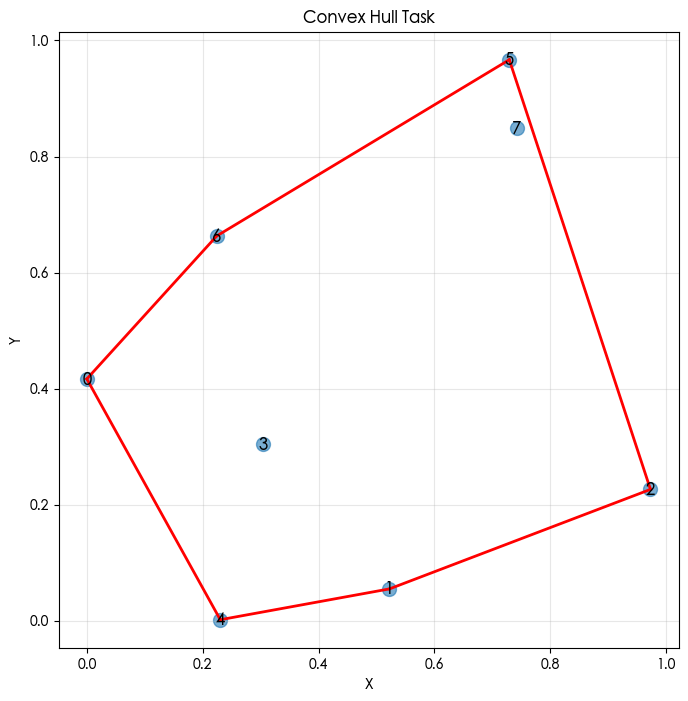


Convex hull order: [2, 5, 6, 0, 4, 1]


In [4]:
def generate_convex_hull_data(num_samples=20, num_points=10):
    """
    Generate random 2D points and their convex hull order
    """
    data = []
    
    for _ in range(num_samples):
        # Generate random points
        points = np.random.rand(num_points, 2)
        
        # Compute convex hull
        try:
            hull = ConvexHull(points)
            hull_indices = hull.vertices.tolist()
            
            # Convert points to input format
            inputs = [points[i:i+1].T for i in range(num_points)]
            
            data.append({
                'points': points,
                'inputs': inputs,
                'hull_indices': hull_indices
            })
        except:
            # Skip degenerate cases
            continue
    
    return data

# Generate data
convex_hull_data = generate_convex_hull_data(num_samples=10, num_points=8)
print(f"Generated {len(convex_hull_data)} convex hull examples")

# Visualize example
example = convex_hull_data[0]
points = example['points']
hull_indices = example['hull_indices']

plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], s=100, alpha=0.6)

# Draw convex hull
for i in range(len(hull_indices)):
    start = hull_indices[i]
    end = hull_indices[(i + 1) % len(hull_indices)]
    plt.plot([points[start, 0], points[end, 0]], 
             [points[start, 1], points[end, 1]], 
             'r-', linewidth=2)

# Label points
for i, (x, y) in enumerate(points):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title('Convex Hull Task')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print(f"\nConvex hull order: {hull_indices}")

## 在凸包上测试指针网络

Untrained Pointer Network:
True convex hull order: [2, 5, 6, 0, 4, 1]
Predicted order: [np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6)]


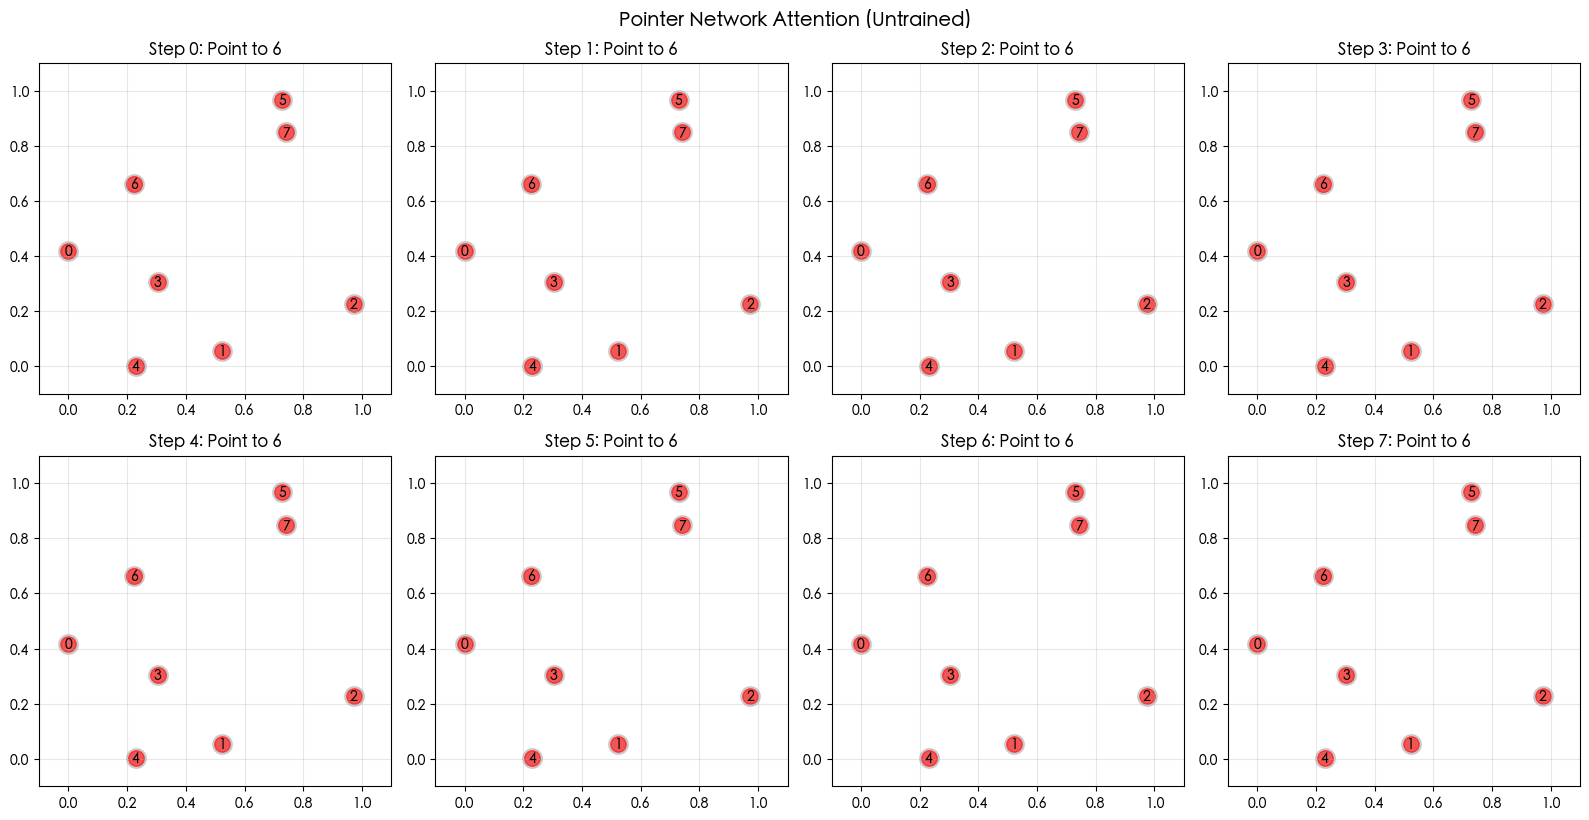

In [5]:
# Create pointer network
ptr_net = PointerNetwork(input_size=2, hidden_size=32)

# Test on example
test_example = convex_hull_data[0]
inputs = test_example['inputs']
true_hull = test_example['hull_indices']

# Forward pass (untrained)
predicted_indices, probs = ptr_net.forward(inputs)

print("Untrained Pointer Network:")
print(f"True convex hull order: {true_hull}")
print(f"Predicted order: {predicted_indices}")

# Visualize attention at each step
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for step in range(min(8, len(probs))):
    ax = axes[step]
    
    # Plot points
    ax.scatter(points[:, 0], points[:, 1], s=200, alpha=0.3, c='gray')
    
    # Highlight attention weights
    attention_weights = probs[step].flatten()
    for i, (x, y) in enumerate(points):
        ax.scatter(x, y, s=1000*attention_weights[i], alpha=0.6, c='red')
        ax.text(x, y, str(i), fontsize=10, ha='center', va='center')
    
    ax.set_title(f'Step {step}: Point to {predicted_indices[step]}')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Pointer Network Attention (Untrained)', y=1.02, fontsize=14)
plt.show()

## 更简单的任务：数字排序

一个更简单的演示，网络学习排序。

Sorting Task Example:
Values: [0.96218591 0.90148585 0.27038324 0.80354178 0.9956042  0.252663  ]
Sorted order (indices): [5, 2, 3, 1, 0, 4]
Sorted values: [0.252663   0.27038324 0.80354178 0.90148585 0.96218591 0.9956042 ]


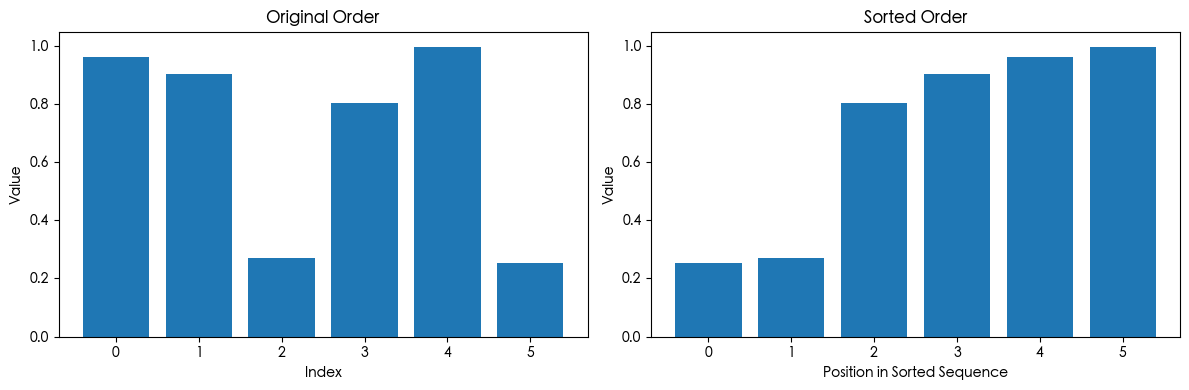

In [6]:
def generate_sorting_data(num_samples=50, seq_len=5):
    """
    Generate random sequences and their sorted order
    """
    data = []
    
    for _ in range(num_samples):
        # Random values
        values = np.random.rand(seq_len)
        
        # Sorted indices
        sorted_indices = np.argsort(values).tolist()
        
        # Convert to input format (1D values)
        inputs = [np.array([[v]]) for v in values]
        
        data.append({
            'values': values,
            'inputs': inputs,
            'sorted_indices': sorted_indices
        })
    
    return data

# Generate sorting data
sort_data = generate_sorting_data(num_samples=20, seq_len=6)

# Test example
example = sort_data[0]
print("Sorting Task Example:")
print(f"Values: {example['values']}")
print(f"Sorted order (indices): {example['sorted_indices']}")
print(f"Sorted values: {example['values'][example['sorted_indices']]}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(example['values'])), example['values'])
plt.title('Original Order')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
sorted_vals = example['values'][example['sorted_indices']]
plt.bar(range(len(sorted_vals)), sorted_vals)
plt.title('Sorted Order')
plt.xlabel('Position in Sorted Sequence')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

## 关键要点

### 指针网络的创新：
1. **输出词汇表就是输入**：网络指向输入元素
2. **可变输出大小**：可以处理不同的输入长度
3. **无固定词汇表**：解决组合问题
4. **注意力即选择**：使用注意力机制来"指向"

### 应用：
- 凸包计算
- 旅行商问题（TSP）
- 排序
- Delaunay三角剖分
- 任何输出是输入的排列/子集的问题

### 架构组件：
1. **编码器**：处理输入序列
2. **解码器**：生成指针序列
3. **注意力**：计算输入位置上的分布
4. **指向**：选择下一个要输出的输入元素

### 训练：
- 使用正确指针序列的监督学习
- 指针分布上的交叉熵损失
- 可以使用强化学习进行优化问题